שם התלמיד

...........................

# Logistic Regression

In this exercise, you will implement logistic regression and apply it to two different datasets.


# Outline
- [ 1 - Packages ](#1)
- [ 2 - Logistic Regression](#2)
  - [ 2.1 Problem Statement](#2.1)
  - [ 2.2 Loading and visualizing the data](#2.2)
  - [ 2.3  Sigmoid function](#2.3)
  - [ 2.4 Cost function for logistic regression](#2.4)
  - [ 2.5 Gradient for logistic regression](#2.5)
  - [ 2.6 Learning parameters using gradient descent ](#2.6)
  - [ 2.7 Plotting the decision boundary](#2.7)
  - [ 2.8 Evaluating logistic regression](#2.8)

<a name="1"></a>
## 1 - Packages

First, let's run the cell below to import all the packages that you will need during this assignment.
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a famous library to plot graphs in Python.
-  ``utils.py`` contains helper functions for this assignment. You do not need to modify code in this file.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#from utils import *
import copy
import math

%matplotlib inline

<a name="2"></a>
## 2 - Logistic Regression

In this part of the exercise, you will build a logistic regression model to predict whether a student gets admitted into a university.

<a name="2.1"></a>
### 2.1 Problem Statement

Suppose that you are the administrator of a university department and you want to determine each applicant’s chance of admission based on their results on two exams.
* You have historical data from previous applicants that you can use as a training set for logistic regression.
* For each training example, you have the applicant’s scores on two exams and the admissions decision.
* Your task is to build a classification model that estimates an applicant’s probability of admission based on the scores from those two exams.

<a name="2.2"></a>
### 2.2 Loading and visualizing the data

You will start by loading the dataset for this task.

  - `X_train` contains exam scores on two exams for a student
  - `y_train` is the admission decision
      - `y_train = 1` if the student was admitted
      - `y_train = 0` if the student was not admitted
  - Both `X_train` and `y_train` are numpy arrays.


In [ ]:
# העלאת הקובץ:
# ex2data1.csv
from google.colab import files
uploaded = files.upload()


Saving ex2data1.csv to ex2data1.csv


In [ ]:
import pandas as pd
import io

df = pd.read_csv(io.BytesIO(uploaded['ex2data1.csv']))
df.head(5)

,exam1,exam2,gets_admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [ ]:
columns_names = df.columns
print(columns_names)

Index(['exam1', 'exam2', 'gets_admitted'], dtype='object')


In [ ]:
# Extracting the features and target variable into separate numpy arrays
X_train = df.drop('gets_admitted', axis=1).values  # Features (all columns except 'gets_admitted')
y_train = df['gets_admitted'].values  # Target variable ('gets_admitted')


#### View the variables
Let's get more familiar with your dataset.  
- A good place to start is to just print out each variable and see what it contains.

The code below prints the first five values of `X_train` and the type of the variable.

In [ ]:
print("First five elements in X_train are:\n", X_train[:5])
print("Type of X_train:",type(X_train))

First five elements in X_train are:
 [[34.62365962 78.02469282]
 [30.28671077 43.89499752]
 [35.84740877 72.90219803]
 [60.18259939 86.3085521 ]
 [79.03273605 75.34437644]]
Type of X_train: <class 'numpy.ndarray'>


Now print the first five values of `y_train`

In [ ]:
print("First five elements in y_train are:\n", y_train[:5])
print("Type of y_train:",type(y_train))

First five elements in y_train are:
 [0 0 0 1 1]
Type of y_train: <class 'numpy.ndarray'>


#### Check the dimensions of your variables

Another useful way to get familiar with your data is to view its dimensions. Let's print the shape of `X_train` and `y_train` and see how many training examples we have in our dataset.

In [ ]:
print ('The shape of X_train is: ' + str(X_train.shape))
print ('The shape of y_train is: ' + str(y_train.shape))
print ('We have m = %d training examples' % (len(y_train)))

The shape of X_train is: (100, 2)
The shape of y_train is: (100,)
We have m = 100 training examples


#### Visualize your data

Before starting to implement any learning algorithm, it is always good to visualize the data if possible.
- The code below displays the data on a 2D plot (as shown below), where the axes are the two exam scores, and the positive and negative examples are shown with different markers.
- We use "plot_data" function to plot the data

In [ ]:
import matplotlib.pyplot as plt

def plot_data(X_train, y_train, pos_label, neg_label,x_label,y_label):
    """
    Plot the training data on a 2D graph.

    Parameters:
    X_train : array-like, shape (n_samples, n_features)
        Training vectors, where n_samples is the number of samples and
        n_features is the number of features.
    y_train : array-like, shape (n_samples,)
        Target values (class labels in classification).
    pos_label : Label for the positive class.
    neg_label : Label for the negative class.
    """
    # Separate positive and negative classes
    pos = X_train[y_train == 1]
    neg = X_train[y_train == 0]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(pos[:, 0], pos[:, 1], s=50, c='b', marker='o', label=pos_label)
    plt.scatter(neg[:, 0], neg[:, 1], s=50, c='r', marker='x', label=neg_label)

    # Set the y-axis label
    plt.ylabel(y_label)
    # Set the x-axis label
    plt.xlabel(x_label)
    plt.legend(loc="upper right")
    plt.show()

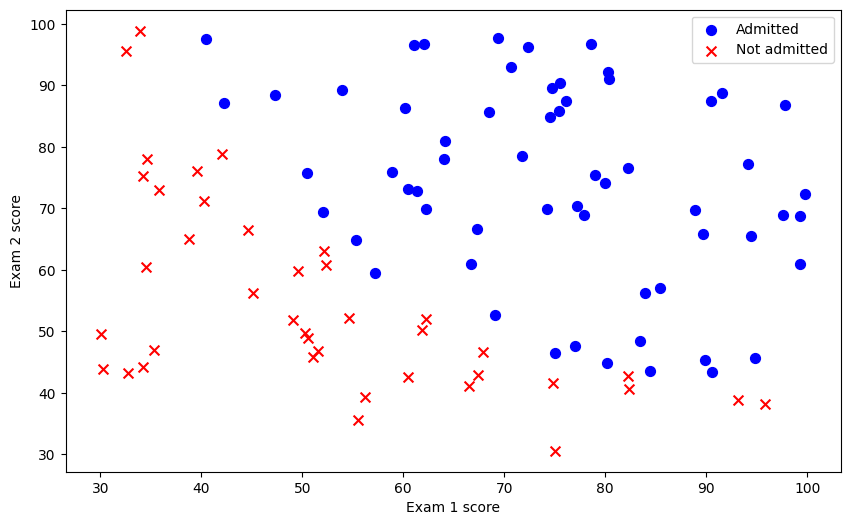

In [ ]:
# Plot examples
plot_data(X_train, y_train[:], "Admitted", "Not admitted","Exam 1 score","Exam 2 score")



Your goal is to build a logistic regression model to fit this data.
- With this model, you can then predict if a new student will be admitted based on their scores on the two exams.

<a name="2.3"></a>
### 2.3  Sigmoid function

Recall that for logistic regression, the model is represented as

$$ f_{\mathbf{w},b}(x) = g(\mathbf{w}\cdot \mathbf{x} + b)$$
where function $g$ is the sigmoid function. The sigmoid function is defined as:

$$g(z) = \frac{1}{1+e^{-z}}$$

Let's implement the sigmoid function first, so it can be used by the rest of this assignment.

<a name='ex-01'></a>
### Exercise 1
Please complete  the `sigmoid` function to calculate

$$g(z) = \frac{1}{1+e^{-z}}$$

Note that
- `z` is not always a single number, but can also be an array of numbers.
- If the input is an array of numbers, we'd like to apply the sigmoid function to each value in the input array.

In [ ]:
# Exercise 1

def sigmoid(z):
    """
    Compute the sigmoid of z

    Args:
        z (ndarray): A scalar, numpy array of any size.

    Returns:
        g (ndarray): sigmoid(z), with the same shape as z

    """

    ### START CODE HERE ###


    ### END SOLUTION ###

    return g

When you are finished, try testing a few values by calling `sigmoid(x)` in the cell below.
- For large positive values of x, the sigmoid should be close to 1, while for large negative values, the sigmoid should be close to 0.
- Evaluating `sigmoid(0)` should give you exactly 0.5.


In [ ]:
print ("sigmoid(0) = " + str(sigmoid(0)))

sigmoid(0) = 0.5


**Expected Output**:
<table>
  <tr>
    <td> <b>sigmoid(0)<b></td>
    <td> 0.5 </td>
  </tr>
</table>
    
- As mentioned before, your code should also work with vectors and matrices. For a matrix, your function should perform the sigmoid function on every element.

In [ ]:
print ("sigmoid([ -1, 0, 1, 2]) = " + str(sigmoid(np.array([-1, 0, 1, 2]))))


sigmoid([ -1, 0, 1, 2]) = [0.26894142 0.5        0.73105858 0.88079708]


**Expected Output**:
<table>
  <tr>
    <td><b>sigmoid([-1, 0, 1, 2])<b></td>
    <td>[0.26894142        0.5           0.73105858        0.88079708]</td>
  </tr>    
  
</table>

<a name="2.4"></a>
### 2.4 Cost function for logistic regression

In this section, you will implement the cost function for logistic regression.

<a name='ex-02'></a>
### Exercise 2

Please complete the `compute_cost` function using the equations below.

Recall that for logistic regression, the cost function is of the form

$$ J(\mathbf{w},b) = \frac{1}{m}\sum_{i=0}^{m-1} \left[ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right] \tag{1}$$

where
* m is the number of training examples in the dataset


* $loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)})$ is the cost for a single data point, which is -

    $$loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) = (-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \tag{2}$$
    
    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$, which is the actual label

*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(\mathbf{w} \cdot \mathbf{x^{(i)}} + b)$ where function $g$ is the sigmoid function.
        
    where $n$ is the number of features

Note:
* As you are doing this, remember that the variables `X_train` and `y_train` are not scalar values but matrices of shape ($m, n$) and ($𝑚$,1) respectively, where  $𝑛$ is the number of features and $𝑚$ is the number of training examples.
* You can use the sigmoid function that you implemented above for this part.


In [ ]:
# Exercise 2
def compute_cost(X, y, w, b):
    """
    Computes the cost over all examples
    Args:
      X : (ndarray Shape (m,n)) data, m examples by n features
      y : (array_like Shape (m,)) target value
      w : (array_like Shape (n,)) Values of parameters of the model
      b : scalar Values of bias parameter of the model

    Returns:
      total_cost: (scalar)         cost
    """

    m, n = X.shape

    ### START CODE HERE ###


    ### END CODE HERE ###

    return cost

Run the cells below to check your implementation of the `compute_cost` function with two different initializations of the parameters $w$

In [ ]:
m, n = X_train.shape

# Compute and display cost with w initialized to zeroes
initial_w = np.zeros(n)
initial_b = 0.
cost = compute_cost(X_train, y_train, initial_w, initial_b)
print('Cost at initial w (zeros): {:.3f}'.format(cost))

Cost at initial w (zeros): 0.693


**Expected Output**:
<table>
  <tr>
    <td> <b>Cost at initial w (zeros)<b></td>
    <td> 0.693 </td>
  </tr>
</table>

In [ ]:
# Compute and display cost with non-zero w
test_w = np.array([0.2, 0.2])
test_b = -24.
cost = compute_cost(X_train, y_train, test_w, test_b)

print('Cost at test w,b: {:.3f}'.format(cost))


Cost at test w,b: 0.218


**Expected Output**:
<table>
  <tr>
    <td> <b>Cost at test w,b<b></td>
    <td> 0.218 </td>
  </tr>
</table>

<a name="2.5"></a>
### 2.5 Gradient for logistic regression

In this section, you will implement the gradient for logistic regression.

Recall that the gradient descent algorithm is:

$$\begin{align*}& \text{repeat until convergence:} \; \lbrace \newline \; & b := b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \newline       \; & w_j := w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1}\newline & \rbrace\end{align*}$$

where, parameters $b$, $w_j$ are all updated simultaniously


<a name='ex-03'></a>
### Exercise 3

Please complete the `compute_gradient` function to compute $\frac{\partial J(\mathbf{w},b)}{\partial w}$, $\frac{\partial J(\mathbf{w},b)}{\partial b}$ from equations (2) and (3) below.

$$
\frac{\partial J(\mathbf{w},b)}{\partial b}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)}) \tag{2}
$$
$$
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  = \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - \mathbf{y}^{(i)})x_{j}^{(i)} \tag{3}
$$
* m is the number of training examples in the dataset

    
*  $f_{\mathbf{w},b}(x^{(i)})$ is the model's prediction, while $y^{(i)}$ is the actual label


- **Note**: While this gradient looks identical to the linear regression gradient, the formula is actually different because linear and logistic regression have different definitions of $f_{\mathbf{w},b}(x)$.

As before, you can use the sigmoid function that you implemented above.

In [ ]:
# Exercise 3
def compute_gradient(X, y, w, b):
    """
    Computes the gradient for logistic regression

    Args:
      X : (ndarray Shape (m,n)) variable such as house size
      y : (array_like Shape (m,1)) actual value
      w : (array_like Shape (n,1)) values of parameters of the model
      b : (scalar)                 value of parameter of the model

    Returns
      dj_dw: (array_like Shape (n,1)) The gradient of the cost w.r.t. the parameters w.
      dj_db: (scalar)                The gradient of the cost w.r.t. the parameter b.
    """
    m, n = X.shape
    dj_dw = np.zeros(w.shape)
    dj_db = 0.

    ### START CODE HERE ###

    ### END CODE HERE ###


    return dj_db, dj_dw

Run the cells below to check your implementation of the `compute_gradient` function with two different initializations of the parameters $w$

In [ ]:
# Compute and display gradient with w initialized to zeroes
initial_w = np.zeros(n)
initial_b = 0.

dj_db, dj_dw = compute_gradient(X_train, y_train, initial_w, initial_b)
print(f'dj_db at initial w (zeros):{dj_db}' )
print(f'dj_dw at initial w (zeros):{dj_dw.tolist()}' )

dj_db at initial w (zeros):-0.1
dj_dw at initial w (zeros):[-12.0092165893, -11.262842205499998]


**Expected Output**:
<table>
  <tr>
    <td> <b>dj_db at initial w (zeros)<b></td>
    <td> -0.1 </td>
  </tr>
  <tr>
    <td> <b>ddj_dw at initial w (zeros):<b></td>
    <td> [-12.00921658929115, -11.262842205513591] </td>
  </tr>
</table>

In [ ]:
# Compute and display cost and gradient with non-zero w
test_w = np.array([ 0.2, -0.5])
test_b = -24
dj_db, dj_dw  = compute_gradient(X_train, y_train, test_w, test_b)

print('dj_db at test_w:', dj_db)
print('dj_dw at test_w:', dj_dw.tolist())

dj_db at test_w: -0.5999999999991071
dj_dw at test_w: [-44.83135361812106, -44.373841249667706]


**Expected Output**:
<table>
  <tr>
    <td> <b>dj_db at initial w (zeros)<b></td>
    <td> -0.5999999999991071 </td>
  </tr>
  <tr>
    <td> <b>ddj_dw at initial w (zeros):<b></td>
    <td>  [-44.8313536178737957, -44.37384124953978] </td>
  </tr>
</table>

<a name="2.6"></a>
### 2.6 Learning parameters using gradient descent

You will now find the optimal parameters of a logistic regression model by using gradient descent.
- You don't need to implement anything for this part. Simply run the cells below.

- A good way to verify that gradient descent is working correctly is to look
at the value of $J(\mathbf{w},b)$ and check that it is decreasing with each step.

- Assuming you have implemented the gradient and computed the cost correctly, your value of $J(\mathbf{w},b)$ should never increase, and should converge to a steady value by the end of the algorithm.

In [ ]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters):
    """
    Performs batch gradient descent to learn theta. Updates theta by taking
    num_iters gradient steps with learning rate alpha

    Args:
      X :    (array_like Shape (m, n)
      y :    (array_like Shape (m,))
      w_in : (array_like Shape (n,))  Initial values of parameters of the model
      b_in : (scalar)                 Initial value of parameter of the model
      cost_function:                  function to compute cost
      alpha : (float)                 Learning rate
      num_iters : (int)               number of iterations to run gradient descent


    Returns:
      w : (array_like Shape (n,)) Updated values of parameters of the model after
          running gradient descent
      b : (scalar)                Updated value of parameter of the model after
          running gradient descent
    """

    # number of training examples
    m = len(X)

    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_history = []

    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db, dj_dw = gradient_function(X, y, w_in, b_in)

        # Update Parameters using w, b, alpha and gradient
        w_in = w_in - alpha * dj_dw
        b_in = b_in - alpha * dj_db

        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion
            cost =  cost_function(X, y, w_in, b_in)
            J_history.append(cost)

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters/10) == 0 or i == (num_iters-1):
            w_history.append(w_in)
            print(f"Iteration {i:4}: Cost {float(J_history[-1]):8.2f}   ")

    return w_in, b_in, J_history, w_history #return w and J,w history for graphing

Now let's run the gradient descent algorithm above to learn the parameters for our dataset.

**Note**

The code block below takes a couple of minutes to run, especially with a non-vectorized version. You can reduce the `iterations` to test your implementation and iterate faster. If you have time, try running 100,000 iterations for better results.

In [ ]:
np.random.seed(1)
intial_w = 0.01 * (np.random.rand(2).reshape(-1,1) - 0.5)
initial_b = -8


# Some gradient descent settings
iterations = 10000
alpha = 0.001

w,b, J_history,_ = gradient_descent(X_train ,y_train, initial_w, initial_b,
                                   compute_cost, compute_gradient, alpha, iterations)

Iteration    0: Cost     1.01   
Iteration 1000: Cost     0.31   
Iteration 2000: Cost     0.30   
Iteration 3000: Cost     0.30   
Iteration 4000: Cost     0.30   
Iteration 5000: Cost     0.30   
Iteration 6000: Cost     0.30   
Iteration 7000: Cost     0.30   
Iteration 8000: Cost     0.30   
Iteration 9000: Cost     0.30   
Iteration 9999: Cost     0.30   


<details>
<summary>
    <b>Expected Output: Cost     0.30, (Click to see details):</b>
</summary>

    # With the following settings
    np.random.seed(1)
    intial_w = 0.01 * (np.random.rand(2).reshape(-1,1) - 0.5)
    initial_b = -8
    iterations = 10000
    alpha = 0.001
    #

```
Iteration    0: Cost     1.01   
Iteration 1000: Cost     0.31   
Iteration 2000: Cost     0.30   
Iteration 3000: Cost     0.30   
Iteration 4000: Cost     0.30   
Iteration 5000: Cost     0.30   
Iteration 6000: Cost     0.30   
Iteration 7000: Cost     0.30   
Iteration 8000: Cost     0.30   
Iteration 9000: Cost     0.30   
Iteration 9999: Cost     0.30   
```

<a name="2.7"></a>
### 2.7 Plotting the decision boundary

We will now use the final parameters from gradient descent to plot the linear fit. If you implemented the previous parts correctly.

In [ ]:
def plot_decision_boundary(X_train, y_train, w, b, f1, f2):


  # Plotting the data and decision boundary
  plt.figure(figsize=(10, 6))
  plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c=y_train)

  # Decision boundary (w*x + b = 0)
  x_values = [np.min(X_train[:, 0]), np.max(X_train[:, 0])]
  x_values = np.array(x_values)  # Convert list to numpy array if it's not already
  y_values = -(b + w[0] * x_values) / w[1]
  plt.plot(x_values, y_values, label="Decision Boundary", color='red')

  plt.title('Logistic Regression Classification')
  plt.xlabel(f1)
  plt.ylabel(f2)
  plt.legend()
  plt.show()

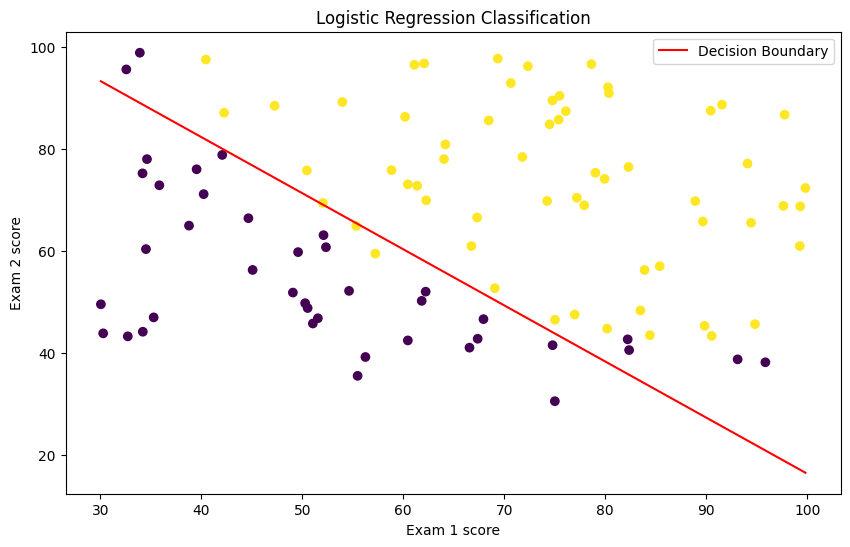

In [ ]:
# Plot examples and decision boundary
plot_decision_boundary(X_train, y_train[:], w, b ,"Exam 1 score","Exam 2 score")

<a name="2.8"></a>
### 2.8 Evaluating logistic regression

We can evaluate the quality of the parameters we have found by seeing how well the learned model predicts on our training set.

You will implement the `predict` function below to do this.


<a name='ex-04'></a>
### Exercise 4

Please complete the `predict` function to produce `1` or `0` predictions given a dataset and a learned parameter vector $w$ and $b$.
- First you need to compute the prediction from the model $f(x^{(i)}) = g(w \cdot x^{(i)})$ for every example
    - You've implemented this before in the parts above
- We interpret the output of the model ($f(x^{(i)})$) as the probability that $y^{(i)}=1$ given $x^{(i)}$ and parameterized by $w$.
- Therefore, to get a final prediction ($y^{(i)}=0$ or $y^{(i)}=1$) from the logistic regression model, you can use the following heuristic -

  if $f(x^{(i)}) >= 0.5$, predict $y^{(i)}=1$
  
  if $f(x^{(i)}) < 0.5$, predict $y^{(i)}=0$
    

In [ ]:
#Exercise 4

def predict(X, w, b):
    """
    Predict whether the label is 0 or 1 using learned logistic
    regression parameters w

    Args:
    X : (ndarray Shape (m, n))
    w : (array_like Shape (n,))      Parameters of the model
    b : (scalar, float)              Parameter of the model

    Returns:
    p: (ndarray (m,1))
        The predictions for X using a threshold at 0.5
    """
    # number of training examples
    m, n = X.shape
    p = np.zeros(m)

    ### START CODE HERE ###



    ### END CODE HERE ###
    return p

Now let's use this to compute the accuracy on the training set

In [ ]:
#Compute accuracy on our training set
p = predict(X_train, w,b)
print('Train Accuracy: %f'%(np.sum(p == y_train)))

Train Accuracy: 92.000000


<table>
  <tr>
    <td> <b>Train Accuracy (approx):<b></td>
    <td> 92.00 </td>
  </tr>
</table>

#Exercise 5 - sklearn
sklearn - רגרסייה לוגיסטית

- ייבוא ספריה

from sklearn.linear_model import LogisticRegression
- מאפיינים

X_Train
- ערכי הפלט

y_train
- הגדרת מסווג

clf = LogisticRegression()
- אימון

clf.fit(X_Train, y_train)


In [ ]:
#Exercise 4 - sklearn
# YOUR CODE HERE
# Train the logistic regression classifier


# import the class
# ?

# instantiate the model
# ?

# fit the model with data
# ?

# predict
# ?

# accuracy
# acc =
print(acc)

Credit to: Coursera-Supervised Machine Learning: Regression and Classification

Modified by: Merav Varsano Maala